## 1、定义算法

ACER算法中主要有几点技术：截断的重要性采样，使得在控制方差的同时可以保证无偏性；一阶置信域方法，使得置信域计算更加简单；使用了retrace，更加有效地计算off-policy值函数。具体内容可以见论文 https://arxiv.org/abs/1611.01224。

### 1.1、定义模型



In [9]:
import torch.nn as nn
import torch.nn.functional as F

class ActorCriticACER(nn.Module):
    def __init__(self, input_dim, output_dim, actor_hidden_dim=128,critic_hidden_dim=128):
        super(ActorCriticACER, self).__init__()

        self.critic_fc1 = nn.Linear(input_dim, critic_hidden_dim)
        self.critic_fc2 = nn.Linear(critic_hidden_dim, output_dim)

        self.actor_fc1 = nn.Linear(input_dim, actor_hidden_dim)
        self.actor_fc2 = nn.Linear(actor_hidden_dim, output_dim)
    
    def forward(self, state):
        value = F.relu(self.critic_fc1(state))
        value = self.critic_fc2(value)
        
        policy_dist = F.relu(self.actor_fc1(state))

        policy_dist = F.softmax(self.actor_fc2(policy_dist), dim=1)

        return value, policy_dist


### 1.2、定义经验回放

In [10]:
from collections import deque, namedtuple
import random
import torch

Transition = namedtuple('Transition', ('states', 'actions', 'rewards', 'next_states',
                                       'done', 'exploration_statistics'))

class ReplayBuffer(object):
    def __init__(self, capacity: int) -> None:
        self.capacity = capacity
        self.buffer = deque([[]], maxlen=self.capacity)
    def push(self,transitions):
        ''' 存储transition到经验回放中
        '''
        if self.buffer[-1] and self.buffer[-1][-1][4]:
            self.buffer.append([])
        self.buffer[-1].append(transitions)
    def sample(self, batch_size: int, window_length=float('inf')):

        batched_trajectory = []
        trajectory_indices = random.choices(range(len(self.buffer)-1), k=min(batch_size, len(self.buffer)-1))
        trajectories = []
        for trajectory in [self.buffer[index] for index in trajectory_indices]:
            start = random.choices(range(len(trajectory)), k=1)[0]
            trajectories.append(trajectory[start:int(start + window_length)])
        smallest_trajectory_length = min([len(trajectory) for trajectory in trajectories]) if trajectories else 0
        for index in range(len(trajectories)):
            trajectories[index] = trajectories[index][-smallest_trajectory_length:]
        
        return trajectories
    

    def clear(self):
        ''' 清空经验回放
        '''
        self.buffer.clear()
    def __len__(self):
        ''' 返回当前存储的量
        '''
        return len(self.buffer)

### 1.3、真定义算法

In [11]:
import torch
import torch.optim as optim
import math
import numpy as np
from torch.distributions import Categorical,Normal
from torch.autograd import Variable
class ACER:
    def __init__(self,model,memory,cfg):

        self.action_dim = cfg.action_dim  
        self.gamma = cfg.gamma
        self.lmbda = cfg.lmbda  # GAE参数
        self.device = torch.device(cfg.device)
        
        self.sample_count = 0
        self.alpha = cfg.alpha
        self.grad_steps = cfg.grad_steps
        self.search_steps = cfg.search_steps

        self.actor_weight = cfg.actor_weight
        self.truncation = cfg.truncation 
        self.entropy_regularization = cfg.entropy_regularization
        self.trust_region_constraint = cfg.trust_region_constraint
        self.tau = cfg.tau
        self.replay_ratio = cfg.replay_ratio
        self.off_policy_minbatch = cfg.off_policy_minbatch
        self.max_replay_size = cfg.max_replay_size

        self.actor_critic = model.to(self.device)
        self.average_actor_critic = model.to(self.device)
        self.average_actor_critic.load_state_dict(self.actor_critic.state_dict())      
        self.optimizer = torch.optim.Adam(self.average_actor_critic.parameters(), lr=cfg.lr)  
        self.memory = memory # 经验回放
        
    def sample_action(self, state):
        ''' 采样动作
        '''
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        _, probs = self.actor_critic(state)
        dist = Categorical(probs)
        action = dist.sample()
        self.probs = probs.data.view(1, -1)
        return action.detach().cpu().numpy().item()

    @torch.no_grad()
    def predict_action(self, state,**kwargs):
        state = torch.tensor(state, device=self.device, dtype=torch.float32).unsqueeze(dim=0)
        _, probs = self.actor_critic(state)
        dist = Categorical(probs)
        action = dist.sample()
        return action.detach().cpu().numpy().item()

    @staticmethod
    def trust_region_update(self, actor_gradients, cur_policy_dist, average_policy_dist):
        negative_kullback_leibler = - ((average_policy_dist.log() - cur_policy_dist.log())
                                       * average_policy_dist).sum(-1)
        kullback_leibler_gradients = torch.autograd.grad(negative_kullback_leibler.mean(),
                                                         cur_policy_dist, retain_graph=True)
        
        updated_actor_gradients = []
        for actor_gradient, kullback_leibler_gradient in zip(actor_gradients, kullback_leibler_gradients):
            scale = actor_gradient.mul(kullback_leibler_gradient).sum(-1).unsqueeze(-1) - self.trust_region_constraint
            scale = torch.div(scale, actor_gradient.mul(actor_gradient).sum(-1).unsqueeze(-1)).clamp(min=0.)
            updated_actor_gradients.append(actor_gradient - scale * kullback_leibler_gradient)
        return updated_actor_gradients


    def update(self, buffer_data, offpolicy= False):
        # 从经验回放中随机采样一个批量的转移(transition)

        if not offpolicy:
            state_batch, action_batch, reward_batch, next_state_batch, done_batch, probs_batch = zip(*buffer_data)
            probs_batch = torch.cat(probs_batch).to(self.device) # shape:[batch_size,n_actions]
        else :
            num_traj = 0
            for trajectory in buffer_data:
                state_traj, action_traj, reward_traj, next_state_traj, done_traj, probs_traj = zip(*trajectory)
                probs_traj = torch.cat(probs_traj).to(self.device)
                if num_traj == 0:
                    state_batch, action_batch, reward_batch, next_state_batch, done_batch, probs_batch = state_traj, action_traj, reward_traj, next_state_traj, done_traj, probs_traj
                else :
                    if len(np.array(state_batch).shape) < 3 :
                        state_batch = np.expand_dims(state_batch, 1); action_batch = np.expand_dims(action_batch, 1)
                        reward_batch = np.expand_dims(reward_batch, 1); next_state_batch = np.expand_dims(next_state_batch, 1)
                        done_batch = np.expand_dims(done_batch, 1); probs_batch = np.expand_dims(probs_batch.cpu().numpy(), 1)
                    state_batch = np.concatenate((state_batch, np.expand_dims(state_traj, 1)), axis = 1)
                    action_batch = np.concatenate((action_batch, np.expand_dims(action_traj, 1)), axis = 1)
                    reward_batch = np.concatenate((reward_batch, np.expand_dims(reward_traj, 1)), axis = 1)
                    next_state_batch = np.concatenate((next_state_batch, np.expand_dims(next_state_traj, 1)), axis = 1)
                    done_batch = np.concatenate((done_batch, np.expand_dims(done_traj, 1)), axis = 1)
                    probs_batch = np.concatenate((probs_batch, np.expand_dims(probs_traj.cpu().numpy(), 1)), axis = 1)
                num_traj += 1
            probs_batch = torch.tensor(probs_batch, device=self.device, dtype=torch.float32) # shape:[batch_size,n_actions]
            
        # 将数据转换为tensor
        state_batch = torch.tensor(np.array(state_batch), device=self.device, dtype=torch.float32) # shape:[batch_size,n_states]
        action_batch = torch.tensor(np.array(action_batch), device=self.device, dtype=torch.long).unsqueeze(dim=1) # shape:[batch_size,1]
        next_state_batch = torch.tensor(np.array(next_state_batch), device=self.device, dtype=torch.float32) # shape:[batch_size,n_states]
        reward_batch = torch.tensor(np.array(reward_batch), device=self.device, dtype=torch.float32).unsqueeze(dim=1) # shape:[batch_size,1]
        done_batch = torch.tensor(np.array(done_batch), device=self.device, dtype=torch.float32).unsqueeze(dim=1) # shape:[batch_size,1]
        next_states = next_state_batch[-1]

        # print ("shape = ", state_batch.shape, action_batch.shape, next_state_batch.shape, reward_batch.shape, done_batch.shape, probs_batch.shape)
        values, policy_dist = self.actor_critic(next_states.unsqueeze(0))
        retrace_action_value = (policy_dist * values).data.sum(-1).unsqueeze(-1)
        episode_len = len(state_batch)

        for i in reversed(range(episode_len)):
            cur_states = state_batch[i]
            cur_actions = action_batch[i] ; cur_rewards = reward_batch[i] ; cur_done = done_batch[i]
            cur_probs = probs_batch[i]

            if len(cur_states.shape) < 2 :
                cur_states = cur_states.unsqueeze(0)
                cur_actions = cur_actions.unsqueeze(0)
            if cur_actions.shape[1] > 1:
                cur_actions = cur_actions.squeeze(0).unsqueeze(1)
                cur_done = cur_done.squeeze(0).unsqueeze(1)
            action_values, policy_dist = self.actor_critic(cur_states)
            _, average_policy_dist = self.average_actor_critic(cur_states)
            ## average_actor_critic
            cur_value = (action_values * policy_dist).data.sum(-1).unsqueeze(-1) * (1. - cur_done)

            importance_weights = policy_dist.data / cur_probs ## inportance sampling
            naive_advantage = action_values.gather(1, cur_actions).data - cur_value
            retrace_action_value = cur_rewards + self.gamma * retrace_action_value * (1. - cur_done)
            retrace_advantage = retrace_action_value - cur_value

            # Actor
            actor_loss = - self.actor_weight * Variable(
                importance_weights.gather(1, cur_actions.data).clamp(max=self.truncation) * retrace_advantage) \
                * policy_dist.gather(1, cur_actions).log()

            bias_correction = - self.actor_weight * Variable((1 - self.truncation / importance_weights).clamp(min=0.) *
                                      naive_advantage * policy_dist.data) * policy_dist.log()   
            actor_loss += bias_correction.sum(-1).unsqueeze(-1)

            actor_gradients = torch.autograd.grad(actor_loss.mean(), policy_dist, retain_graph=True)
            actor_gradients = self.trust_region_update(self, actor_gradients=actor_gradients, cur_policy_dist=policy_dist, average_policy_dist=Variable(average_policy_dist.data))
            policy_dist.backward(actor_gradients, retain_graph=True)  

            # Critic
            critic_loss = (action_values.gather(-1, cur_actions) - Variable(retrace_action_value)).pow(2)
            critic_loss.mean().backward(retain_graph=True)

            # Entropy
            entropy_loss = self.entropy_regularization * (policy_dist * policy_dist.log()).sum(-1)
            entropy_loss.mean().backward(retain_graph=True)

            retrace_action_value = importance_weights.gather(-1, cur_actions.data).clamp(max=1.) * \
                                   (retrace_action_value - action_values.gather(-1, cur_actions).data) + cur_value                      

        self.optimizer.step()
        for param, average_param in zip(self.actor_critic.parameters(), self.average_actor_critic.parameters()):
            average_param.data.copy_(self.tau * param.data + (1 - self.tau) * average_param.data)        



## 2、定义训练

In [12]:
def train(cfg, env, agent):
    ''' 训练
    '''
    print("开始训练！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg.train_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state, info = env.reset(seed = cfg.seed)  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            ep_step += 1
            action = agent.sample_action(state)  # 选择动作
            next_state, reward, terminated, truncated , info = env.step(action)  # 更新环境，返回transition
            agent.memory.push((state, action, reward, next_state, terminated, agent.probs))  # 保存transition
            state = next_state  # 更新下一个状态
            
            ep_reward += reward  # 累加奖励
            if terminated:
                break

        steps.append(ep_step)
        rewards.append(ep_reward)
        last_trajectory = agent.memory.buffer[-1] 
        agent.update(last_trajectory)  # 更新智能体 on policy 
        off_policy_time = np.random.poisson(agent.replay_ratio)
        for trajectory_count in range(off_policy_time): # off policy 
            trajectory = agent.memory.sample(agent.off_policy_minbatch, agent.max_replay_size)
            if trajectory:
                agent.update(trajectory, offpolicy=True)

        if (i_ep + 1) % 1 == 0:
            print(f"回合：{i_ep+1}/{cfg.train_eps}，奖励：{ep_reward:.2f}")
    print("完成训练！")
    env.close()
    return {'rewards':rewards}

def test(cfg, env, agent):
    print("开始测试！")
    rewards = []  # 记录所有回合的奖励
    steps = []
    for i_ep in range(cfg.test_eps):
        ep_reward = 0  # 记录一回合内的奖励
        ep_step = 0
        state, info = env.reset(seed = cfg.seed)  # 重置环境，返回初始状态
        for _ in range(cfg.max_steps):
            ep_step+=1
            action = agent.predict_action(state)  # 选择动作
            next_state, reward, terminated, truncated , info = env.step(action)  # 更新环境，返回transition
            state = next_state  # 更新下一个状态
            ep_reward += reward  # 累加奖励
            if terminated:
                break
        steps.append(ep_step)
        rewards.append(ep_reward)
        print(f"回合：{i_ep+1}/{cfg.test_eps}，奖励：{ep_reward:.2f}")
    print("完成测试")
    env.close()
    return {'rewards':rewards}

## 3. 定义环境

In [13]:
import gymnasium as gym
import os
def all_seed(seed = 1):
    ''' 万能的seed函数
    '''
    if seed == 0: # 不设置seed
        return 
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed) # CPU 设置
    torch.cuda.manual_seed(seed) # GPU 设置
    os.environ['PYTHONHASHSEED'] = str(seed) # python scripts 设置
    # cudnn 设置
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False
def env_agent_config(cfg):
    env = gym.make(cfg.env_id) # 创建环境
    all_seed(seed=cfg.seed)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n
    print(f"状态空间维度：{state_dim}，动作空间维度：{action_dim}")
    setattr(cfg,"state_dim",state_dim) # 更新state_dim到cfg参数中
    setattr(cfg,"action_dim",action_dim) # 更新action_dim到cfg参数中
    model = ActorCriticACER(state_dim, action_dim) # 创建模型
    memory = ReplayBuffer(cfg.memory_capacity)
    agent = ACER(model,memory,cfg)
    return env,agent

## 4、设置参数

In [14]:
import argparse
import matplotlib.pyplot as plt
import seaborn as sns

class Config:
    def __init__(self) -> None:
        self.algo_name = 'DQN' # 算法名称
        self.env_id = 'CartPole-v1' # 环境id
        self.seed = 1 # 随机种子，便于复现，0表示不设置
        self.train_eps = 120 # 训练的回合数 # 120
        self.test_eps = 20 # 测试的回合数
        self.max_steps = 200 # 每个回合的最大步数，超过该数则游戏强制终止
        self.gamma = 0.99 # 折扣因子
        self.memory_capacity = 100000 # 经验回放池的容量
        
        self.actor_weight = 0.1 # 用于算 actor loss
        self.truncation = 10 # 用于截断
        self.entropy_regularization = 1e-3 # 用于算 entropy loss
        self.trust_region_constraint = 1 # 用于置信域计算
        self.tau = 0.01 # 用于权重更新
        self.replay_ratio = 2 # off policy 采样多少
        self.off_policy_minbatch = 4 # 用于off policy的batch
        self.max_replay_size = 200 # 最长replay的长度

        self.grad_steps = 10
        self.search_steps = 15
        self.alpha = 0.5
        self.lr = 1e-3 # 学习率
        self.lmbda = 0.95
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 检测gpu
        
def smooth(data, weight=0.9):  
    '''用于平滑曲线，类似于Tensorboard中的smooth曲线
    '''
    last = data[0] 
    smoothed = []
    for point in data:
        smoothed_val = last * weight + (1 - weight) * point  # 计算平滑值
        smoothed.append(smoothed_val)                    
        last = smoothed_val                                
    return smoothed

def plot_rewards(rewards,cfg, tag='train'):
    ''' 画图
    '''
    sns.set()
    plt.figure()  # 创建一个图形实例，方便同时多画几个图
    plt.title(f"{tag}ing curve on {cfg.device} of {cfg.algo_name} for {cfg.env_id}")
    plt.xlabel('epsiodes')
    plt.plot(rewards, label='rewards')
    plt.plot(smooth(rewards), label='smoothed')
    plt.legend()
    plt.show()


## 5、开始训练

状态空间维度：4，动作空间维度：2
开始训练！
回合：1/120，奖励：25.00


/tmp/ipykernel_19043/2082297267.py:93: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  probs_batch = torch.tensor(probs_batch, device=self.device, dtype=torch.float32) # shape:[batch_size,n_actions]


回合：2/120，奖励：15.00
回合：3/120，奖励：13.00
回合：4/120，奖励：14.00
回合：5/120，奖励：18.00
回合：6/120，奖励：16.00
回合：7/120，奖励：14.00
回合：8/120，奖励：17.00
回合：9/120，奖励：30.00
回合：10/120，奖励：24.00
回合：11/120，奖励：20.00
回合：12/120，奖励：14.00
回合：13/120，奖励：18.00
回合：14/120，奖励：14.00
回合：15/120，奖励：12.00
回合：16/120，奖励：14.00
回合：17/120，奖励：28.00
回合：18/120，奖励：21.00
回合：19/120，奖励：21.00
回合：20/120，奖励：19.00
回合：21/120，奖励：43.00
回合：22/120，奖励：42.00
回合：23/120，奖励：32.00
回合：24/120，奖励：19.00
回合：25/120，奖励：17.00
回合：26/120，奖励：27.00
回合：27/120，奖励：21.00
回合：28/120，奖励：32.00
回合：29/120，奖励：47.00
回合：30/120，奖励：24.00
回合：31/120，奖励：71.00
回合：32/120，奖励：31.00
回合：33/120，奖励：16.00
回合：34/120，奖励：23.00
回合：35/120，奖励：21.00
回合：36/120，奖励：10.00
回合：37/120，奖励：21.00
回合：38/120，奖励：21.00
回合：39/120，奖励：24.00
回合：40/120，奖励：23.00
回合：41/120，奖励：22.00
回合：42/120，奖励：19.00
回合：43/120，奖励：21.00
回合：44/120，奖励：26.00
回合：45/120，奖励：30.00
回合：46/120，奖励：24.00
回合：47/120，奖励：27.00
回合：48/120，奖励：26.00
回合：49/120，奖励：26.00
回合：50/120，奖励：30.00
回合：51/120，奖励：33.00
回合：52/120，奖励：39.00
回合：53/120，奖励：40.00
回合：54/120，奖励：36.00
回

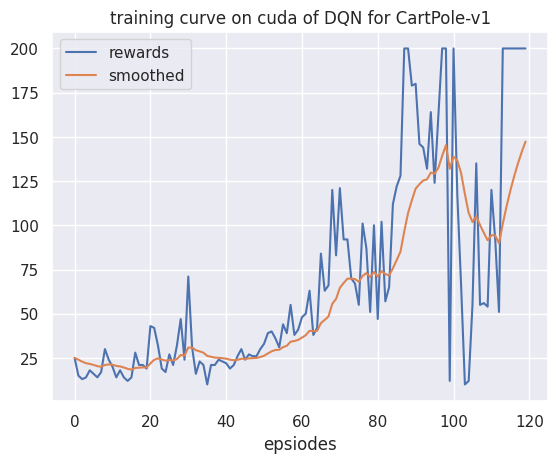

开始测试！
回合：1/20，奖励：200.00
回合：2/20，奖励：200.00
回合：3/20，奖励：200.00
回合：4/20，奖励：200.00
回合：5/20，奖励：200.00
回合：6/20，奖励：200.00
回合：7/20，奖励：200.00
回合：8/20，奖励：200.00
回合：9/20，奖励：200.00
回合：10/20，奖励：200.00
回合：11/20，奖励：200.00
回合：12/20，奖励：200.00
回合：13/20，奖励：200.00
回合：14/20，奖励：200.00
回合：15/20，奖励：200.00
回合：16/20，奖励：200.00
回合：17/20，奖励：200.00
回合：18/20，奖励：200.00
回合：19/20，奖励：166.00
回合：20/20，奖励：200.00
完成测试


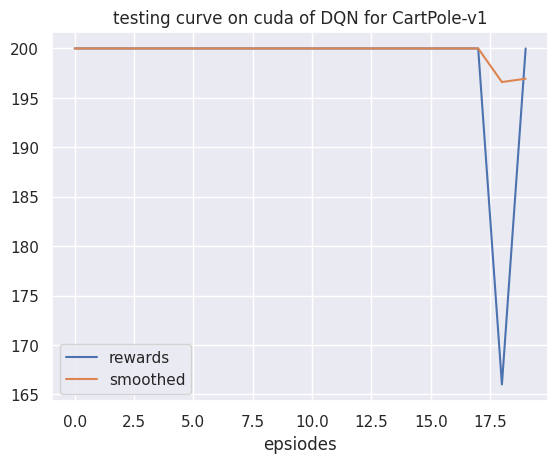

In [15]:
# 获取参数
cfg = Config() 
# 训练
env, agent = env_agent_config(cfg)
res_dic = train(cfg, env, agent)
 
plot_rewards(res_dic['rewards'], cfg, tag="train")  
# 测试
res_dic = test(cfg, env, agent)
plot_rewards(res_dic['rewards'], cfg, tag="test")  # 画出结果